In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\thoma\\Desktop\\ev-modelling-repo\\Data\\NHTS_trips_processed.csv")

In [3]:
df.shape

(795163, 12)

# Nur 1. Weg und dessen Startzeit relevant

### Achtung: W_NR (Weg Nummer) scheinbar nicht explizit in MiD Studie -> Ermittlung dort auf andere Art und Weise

In [4]:
filt = df["W_NR"] == 1
first_trip = df[filt]["W_SZ_MIN"]

In [5]:
first_trip.value_counts()

450     8005
600     7562
480     7305
540     7067
420     6730
        ... 
1268       1
1208       1
1430       1
1286       1
289        1
Name: W_SZ_MIN, Length: 1052, dtype: int64

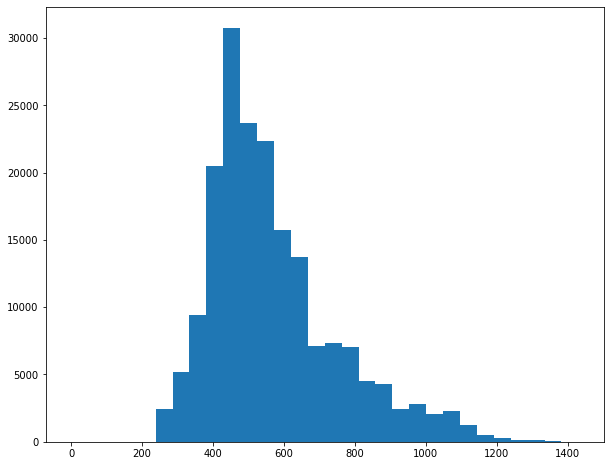

In [80]:
plt.figure(figsize=(10,8))
count, bins, ignored = plt.hist(first_trip, bins = 30 )

# Gaussian Mixture Model ermitteln

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
model_data = np.array(first_trip).reshape(-1,1)

In [82]:
gm_models = [None for i in range(15)]
model_data = np.array(first_trip).reshape(-1,1)
for i in range(1, 16):
    gm_models[i-1] = GaussianMixture(n_components=i, n_init=10).fit(model_data)
    

## Bestimme bestes Model anhand 'theoretical information criterion' 
* je kleiner desto besser
* Bestrafung komplexerer Systeme (mehr Komponenten)
* Belohnung besserer fit zu den Daten


In [83]:
AIC = [m.aic(model_data) for m in gm_models]
BIC = [m.bic(model_data) for m in gm_models]

In [84]:
m_best = gm_models[np.argmin(AIC)]

# Ergebnis plotten

* logprob = logarithmische Wahrscheinlichkeit der x-Werte 
* responsibilities = Anteil der individuellen Normalverteilungen an der Gesamtwahrscheinlichkeit

In [85]:
x = np.linspace(-50, 1450, 10000)
logprob = m_best.score_samples(x.reshape(-1, 1))
responsibilities = m_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

Text(0, 0.5, 'relative Wahrscheinlichkeit')

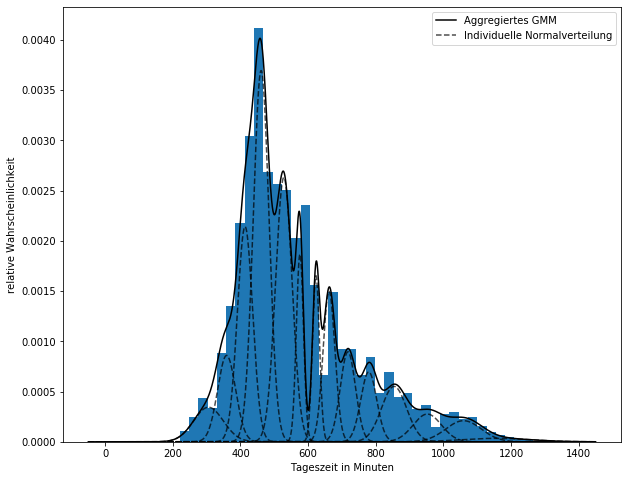

In [99]:
plt.figure(figsize=(10,8))
plt.hist(first_trip, bins=52, density=True);
plt.plot(x, pdf, '-k');
plt.plot(x, pdf_individual, '--k', alpha=0.7);
labels = ["Aggregiertes GMM", "Individuelle Normalverteilung"]
plt.legend(labels)
plt.xlabel("Tageszeit in Minuten")
plt.ylabel("relative Wahrscheinlichkeit")

## Achtung Unterteilung Wochentag/Werktag nicht berücksichtigt